In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from transformers import ViTMAEForPreTraining
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformation
img_size = 224
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load CIFAR-10 and create known/unknown splits.
# In this example, classes 0-4 are considered "seen" and 5-9 are "unseen".
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
known_classes = [0, 1, 2, 3, 4]   # seen classes
unknown_classes = [5, 6, 7, 8, 9]  # unseen classes

known_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in known_classes]
unknown_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in unknown_classes]
known_data = Subset(train_dataset_full, known_idxs)
unknown_data = Subset(train_dataset_full, unknown_idxs)

train_loader = DataLoader(known_data, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(unknown_data, batch_size=16, shuffle=False)

# -------------------------------
# Build a classifier based on the pre-trained MAE encoder
# -------------------------------
class ViTMAEClassifier(nn.Module):
    def __init__(self, mae_model, num_classes, freeze_encoder=False):
        super(ViTMAEClassifier, self).__init__()
        # Use the full base model so that input images are processed correctly (patch embedding, etc.)
        self.encoder = mae_model.base_model  
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        hidden_size = mae_model.config.hidden_size  # token embedding size (e.g. 768)

        # Classification head: maps the [CLS] token representation to the known classes.
        self.cls_head = nn.Linear(hidden_size, num_classes)

        # Auxiliary reconstruction head for anomaly detection.
        # This branch tries to reconstruct the [CLS] token.
        self.rec_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, x):
        # x: input image tensor, shape [B, 3, H, W]
        # Pass through the full base model that includes patch embedding.
        enc_out = self.encoder(x).last_hidden_state  # shape: [B, num_tokens, hidden_size]
        # Use the first token ([CLS] token) as the global image representation.
        cls_token = enc_out[:, 0]  # shape: [B, hidden_size]
        logits = self.cls_head(cls_token)
        rec_output = self.rec_head(cls_token)  # Auxiliary reconstruction branch.
        return logits, rec_output, cls_token

# Load the pre-trained MAE model.
mae_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)

# Build our classifier with 5 seen classes.
num_seen_classes = len(known_classes)  # 5 in this example
model = ViTMAEClassifier(mae_model, num_seen_classes, freeze_encoder=False).to(device)

# Define loss functions and optimizer.
classification_loss_fn = nn.CrossEntropyLoss()
reconstruction_loss_fn = nn.MSELoss()  # reconstruction error on the [CLS] token.
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# -------------------------------
# Training loop (fine-tuning on seen classes)
# -------------------------------
num_epochs = 25
training_log = {"epochs": []}
for epoch in range(num_epochs):
    model.train()
    running_class_loss = 0.0
    running_rec_loss = 0.0
    correct, total = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        logits, rec_output, cls_token = model(images)
        # Classification loss (cross entropy)
        class_loss = classification_loss_fn(logits, labels)
        # Reconstruction loss on [CLS] token
        rec_loss = reconstruction_loss_fn(rec_output, cls_token.detach())
        # Weighted sum of losses
        loss = class_loss + 0.5 * rec_loss
        loss.backward()
        optimizer.step()

        running_class_loss += class_loss.item()
        running_rec_loss += rec_loss.item()
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        progress_bar.set_postfix(class_loss=f"{class_loss.item():.4f}",
                                 rec_loss=f"{rec_loss.item():.4f}",
                                 acc=f"{(100*correct/total):.2f}%")
        
    epoch_log = {
        "epoch": epoch+1,
        "avg_class_loss": running_class_loss/len(train_loader),
        "avg_rec_loss": running_rec_loss/len(train_loader),
        "train_acc": 100*correct/total
    }
    training_log["epochs"].append(epoch_log)
    print(f"Epoch {epoch+1} - Train Accuracy: {100*correct/total:.2f}%")
    
# Save training log and model weights.
os.makedirs("./mae_finetune_outputs", exist_ok=True)
with open("./mae_finetune_outputs/training_log.json", "w") as f:
    json.dump(training_log, f, indent=4)
torch.save(model.state_dict(), "./mae_finetune_outputs/mae_classifier.pth")

# -------------------------------
# Inference: Combining Classification and Anomaly Score
# -------------------------------
model.eval()
anomaly_threshold = 0.1  # Adjust this threshold using a validation set
results = []
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        logits, rec_output, cls_token = model(images)
        # Compute classification probabilities
        probs = torch.softmax(logits, dim=1)
        # Compute anomaly (reconstruction) error on the [CLS] token.
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1)  # one error per image
        
        # Decide seen vs. unseen: if the reconstruction error is higher than the threshold, mark as unseen.
        for i in range(images.size(0)):
            if rec_error[i] > anomaly_threshold:
                pred = "unseen"
            else:
                pred_class = probs[i].argmax().item()
                pred = f"seen_class_{pred_class}"
            results.append(pred)

print("Inference results on validation (unknown) set:")
print(results)


100%|██████████| 170498071/170498071 [06:39<00:00, 426472.64it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 1563/1563 [01:19<00:00, 19.69it/s, acc=83.42%, class_loss=0.0839, rec_loss=0.0105]


Epoch 1 - Train Accuracy: 83.42%


Epoch 2/25: 100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s, acc=90.51%, class_loss=0.0998, rec_loss=0.0074]


Epoch 2 - Train Accuracy: 90.51%


Epoch 3/25: 100%|██████████| 1563/1563 [01:14<00:00, 20.87it/s, acc=92.25%, class_loss=0.0109, rec_loss=0.0041]


Epoch 3 - Train Accuracy: 92.25%


Epoch 4/25: 100%|██████████| 1563/1563 [01:18<00:00, 19.98it/s, acc=93.10%, class_loss=1.1152, rec_loss=0.0036]


Epoch 4 - Train Accuracy: 93.10%


Epoch 5/25: 100%|██████████| 1563/1563 [01:15<00:00, 20.58it/s, acc=93.70%, class_loss=0.0634, rec_loss=0.0022]


Epoch 5 - Train Accuracy: 93.70%


Epoch 6/25: 100%|██████████| 1563/1563 [01:17<00:00, 20.28it/s, acc=94.50%, class_loss=0.2546, rec_loss=0.0018]


Epoch 6 - Train Accuracy: 94.50%


Epoch 7/25: 100%|██████████| 1563/1563 [01:16<00:00, 20.38it/s, acc=95.24%, class_loss=0.0216, rec_loss=0.0018]


Epoch 7 - Train Accuracy: 95.24%


Epoch 8/25: 100%|██████████| 1563/1563 [01:18<00:00, 19.93it/s, acc=95.36%, class_loss=0.0402, rec_loss=0.0012]


Epoch 8 - Train Accuracy: 95.36%


Epoch 9/25: 100%|██████████| 1563/1563 [01:04<00:00, 24.19it/s, acc=95.62%, class_loss=0.1057, rec_loss=0.0010]


Epoch 9 - Train Accuracy: 95.62%


Epoch 10/25: 100%|██████████| 1563/1563 [01:17<00:00, 20.23it/s, acc=95.90%, class_loss=0.0681, rec_loss=0.0011]


Epoch 10 - Train Accuracy: 95.90%


Epoch 11/25: 100%|██████████| 1563/1563 [01:17<00:00, 20.11it/s, acc=95.97%, class_loss=0.0035, rec_loss=0.0008]


Epoch 11 - Train Accuracy: 95.97%


Epoch 12/25: 100%|██████████| 1563/1563 [01:04<00:00, 24.08it/s, acc=96.52%, class_loss=0.4947, rec_loss=0.0007]


Epoch 12 - Train Accuracy: 96.52%


Epoch 13/25: 100%|██████████| 1563/1563 [01:14<00:00, 21.07it/s, acc=96.60%, class_loss=0.0177, rec_loss=0.0007]


Epoch 13 - Train Accuracy: 96.60%


Epoch 14/25: 100%|██████████| 1563/1563 [01:12<00:00, 21.53it/s, acc=96.86%, class_loss=0.0035, rec_loss=0.0004]


Epoch 14 - Train Accuracy: 96.86%


Epoch 15/25: 100%|██████████| 1563/1563 [01:18<00:00, 19.88it/s, acc=97.08%, class_loss=0.0198, rec_loss=0.0005]


Epoch 15 - Train Accuracy: 97.08%


Epoch 16/25: 100%|██████████| 1563/1563 [01:17<00:00, 20.23it/s, acc=97.10%, class_loss=0.0439, rec_loss=0.0005]


Epoch 16 - Train Accuracy: 97.10%


Epoch 17/25: 100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s, acc=97.25%, class_loss=0.0366, rec_loss=0.0005]


Epoch 17 - Train Accuracy: 97.25%


Epoch 18/25: 100%|██████████| 1563/1563 [01:11<00:00, 21.73it/s, acc=97.27%, class_loss=0.0025, rec_loss=0.0004]


Epoch 18 - Train Accuracy: 97.27%


Epoch 19/25: 100%|██████████| 1563/1563 [01:13<00:00, 21.35it/s, acc=97.46%, class_loss=0.0542, rec_loss=0.0003]


Epoch 19 - Train Accuracy: 97.46%


Epoch 20/25: 100%|██████████| 1563/1563 [01:12<00:00, 21.60it/s, acc=97.62%, class_loss=0.0015, rec_loss=0.0003]


Epoch 20 - Train Accuracy: 97.62%


Epoch 21/25: 100%|██████████| 1563/1563 [01:13<00:00, 21.33it/s, acc=97.55%, class_loss=0.0016, rec_loss=0.0003]


Epoch 21 - Train Accuracy: 97.55%


Epoch 22/25: 100%|██████████| 1563/1563 [01:11<00:00, 21.86it/s, acc=97.77%, class_loss=0.1831, rec_loss=0.0003]


Epoch 22 - Train Accuracy: 97.77%


Epoch 23/25: 100%|██████████| 1563/1563 [01:12<00:00, 21.66it/s, acc=97.70%, class_loss=0.0154, rec_loss=0.0003]


Epoch 23 - Train Accuracy: 97.70%


Epoch 24/25: 100%|██████████| 1563/1563 [01:15<00:00, 20.68it/s, acc=97.87%, class_loss=0.0020, rec_loss=0.0003]


Epoch 24 - Train Accuracy: 97.87%


Epoch 25/25: 100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s, acc=97.93%, class_loss=0.0282, rec_loss=0.0002]


Epoch 25 - Train Accuracy: 97.93%
Inference results on validation (unknown) set:
['seen_class_3', 'seen_class_1', 'seen_class_0', 'seen_class_4', 'seen_class_0', 'seen_class_0', 'seen_class_4', 'seen_class_1', 'seen_class_0', 'seen_class_0', 'seen_class_1', 'seen_class_3', 'seen_class_3', 'seen_class_3', 'seen_class_2', 'seen_class_0', 'seen_class_4', 'seen_class_3', 'seen_class_4', 'seen_class_2', 'seen_class_3', 'seen_class_2', 'seen_class_1', 'seen_class_3', 'seen_class_0', 'seen_class_0', 'seen_class_4', 'seen_class_0', 'seen_class_2', 'seen_class_1', 'seen_class_3', 'seen_class_2', 'seen_class_0', 'seen_class_3', 'seen_class_3', 'seen_class_4', 'seen_class_3', 'seen_class_4', 'seen_class_1', 'seen_class_4', 'seen_class_0', 'seen_class_0', 'seen_class_1', 'seen_class_3', 'seen_class_2', 'seen_class_0', 'seen_class_3', 'seen_class_0', 'seen_class_1', 'seen_class_0', 'seen_class_0', 'seen_class_4', 'seen_class_3', 'seen_class_1', 'seen_class_0', 'seen_class_3', 'seen_class_3', 'seen_

In [4]:
torch.save(model.state_dict(), "./mae_finetune_outputs/mae_classifier_25epoch.pth")


In [9]:
# During training:
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
known_classes = [0, 1, 2, 3, 4]
unknown_classes = [5, 6, 7, 8, 9]

known_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in known_classes]
unknown_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in unknown_classes]
known_data = Subset(train_dataset_full, known_idxs)
unknown_data = Subset(train_dataset_full, unknown_idxs)

train_loader = DataLoader(known_data, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(unknown_data, batch_size=16, shuffle=False)


Files already downloaded and verified


In [11]:
from torch.utils.data import ConcatDataset, DataLoader

# Create labels for calibration:
# For known_data samples, we'll assign label 0 ("seen")
# For unknown_data samples, assign label 1 ("unseen")
# Note: You can store these separately or wrap your subsets with a custom dataset that returns these labels.
class LabeledDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, label):
        self.dataset = dataset  # the original dataset
        self.label = label      # integer: 0 for seen, 1 for unseen
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # ignore original CIFAR-10 label
        return img, self.label

# Wrap known_data and unknown_data with our custom labeled dataset
labeled_known = LabeledDataset(known_data, 0)
labeled_unknown = LabeledDataset(unknown_data, 1)

# Optionally, if you want to balance the calibration set, you might take a subset.
# For simplicity here, we merge them directly.
calibration_dataset = ConcatDataset([labeled_known, labeled_unknown])
calibration_loader = DataLoader(calibration_dataset, batch_size=16, shuffle=False)


In [12]:
import numpy as np
model.eval()
all_rec_errors = []
all_ground_truth = []  # 0: seen, 1: unseen

with torch.no_grad():
    for images, gt in calibration_loader:
        images = images.to(device)
        logits, rec_output, cls_token = model(images)
        # Compute error (mean squared error) per sample
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1).cpu().numpy()
        all_rec_errors.extend(rec_error)
        all_ground_truth.extend(gt.numpy())

all_rec_errors = np.array(all_rec_errors)
all_ground_truth = np.array(all_ground_truth)


In [17]:
thresholds = np.linspace(all_rec_errors.min(), all_rec_errors.max(), 50)  # 50 candidate thresholds
accuracy_per_thresh = []

for t in thresholds:
    # Mark as unseen (1) if error > threshold, else seen (0)
    preds = (all_rec_errors > t).astype(int)
    accuracy = (preds == all_ground_truth).mean()
    accuracy_per_thresh.append(accuracy)

best_threshold_idx = np.argmax(accuracy_per_thresh)
best_threshold_acc = thresholds[best_threshold_idx]
best_acc = accuracy_per_thresh[best_threshold_idx]

print(f"Best threshold (accuracy) = {best_threshold_acc:.4f} with accuracy = {best_acc:.4f}")


Best threshold (accuracy) = 0.0002 with accuracy = 0.7078


In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(all_ground_truth, all_rec_errors)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
best_threshold_roc = roc_thresholds[optimal_idx]

print(f"ROC AUC = {roc_auc:.4f}")
print(f"Optimal threshold by max(TPR - FPR) = {best_threshold_roc:.4f}")


ROC AUC = 0.7748
Optimal threshold by max(TPR - FPR) = 0.0002


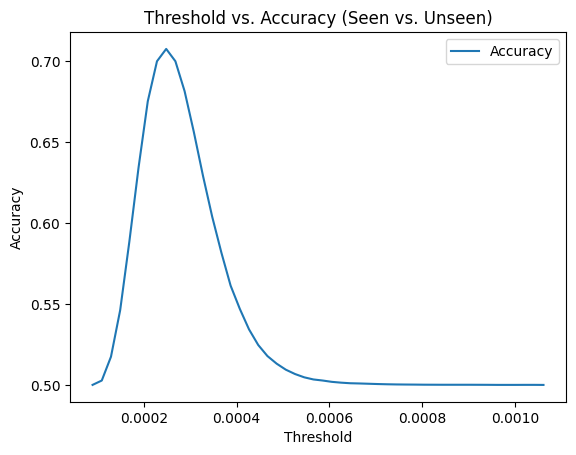

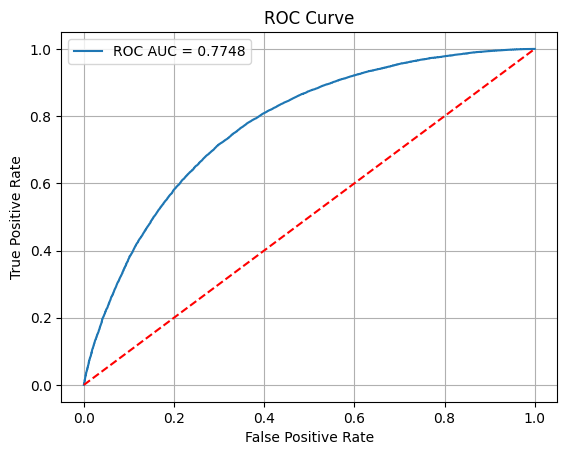

In [25]:
import matplotlib.pyplot as plt

plt.plot(thresholds, accuracy_per_thresh, label='Accuracy')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Threshold vs. Accuracy (Seen vs. Unseen)")
plt.legend()
plt.savefig("./mae_finetune_outputs/Threshold_vs_accuracy.png", dpi=300)
plt.show()

plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("./mae_finetune_outputs/roc_curve1.png", dpi=300)
plt.show()


In [19]:
from sklearn.metrics import f1_score

f1_per_thresh = []
for t in thresholds:
    preds = (all_rec_errors > t).astype(int)
    f1 = f1_score(all_ground_truth, preds)
    f1_per_thresh.append(f1)

best_threshold_idx = np.argmax(f1_per_thresh)
best_threshold_f1 = thresholds[best_threshold_idx]
best_f1 = f1_per_thresh[best_threshold_idx]

print(f"Best threshold (F1) = {best_threshold_f1:.4f} with F1 score = {best_f1:.4f}")


Best threshold (F1) = 0.0002 with F1 score = 0.7346


Confusion Matrix:
[[11218 13782]
 [ 2543 22457]]
Classification Report:
              precision    recall  f1-score   support

        seen       0.82      0.45      0.58     25000
      unseen       0.62      0.90      0.73     25000

    accuracy                           0.67     50000
   macro avg       0.72      0.67      0.66     50000
weighted avg       0.72      0.67      0.66     50000



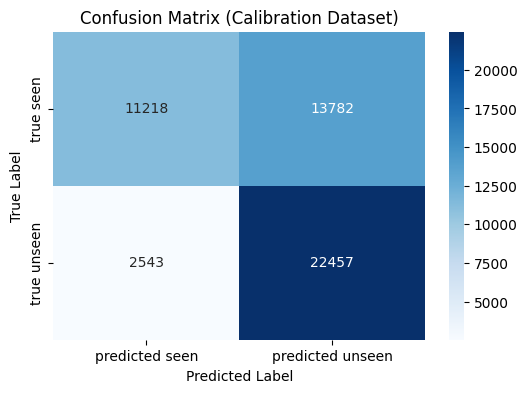

In [26]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assume anomaly_threshold is set based on your calibration (e.g., best_threshold_f1)
anomaly_threshold = best_threshold_f1  # from your threshold tuning

# Use the calibration_loader that combines seen (label 0) and unseen (label 1) data.
model.eval()
all_preds = []    # To store predicted labels (as integers: 0 for seen, 1 for unseen)
all_targets = []  # To store the true labels (0 for seen, 1 for unseen)

with torch.no_grad():
    for images, labels in calibration_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        logits, rec_output, cls_token = model(images)
        probs = torch.softmax(logits, dim=1)
        
        # Compute reconstruction error per sample (MSE on [CLS] token)
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1)
        
        # For calibration we decide based solely on reconstruction error:
        # If error > anomaly_threshold, we predict unseen (label 1),
        # else we predict seen (label 0).
        preds = (rec_error > anomaly_threshold).int()  # tensor containing 0's and 1's
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Compute confusion matrix.
# Here, label 0 corresponds to "seen" and label 1 corresponds to "unseen".
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1])
print("Confusion Matrix:")
print(cm)

# Print a classification report.
report = classification_report(all_targets, all_preds, target_names=["seen", "unseen"])
print("Classification Report:")
print(report)

# Plot the confusion matrix using seaborn.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["predicted seen", "predicted unseen"],
            yticklabels=["true seen", "true unseen"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Calibration Dataset)")
plt.savefig("./mae_finetune_outputs/confusion_matrix_25epochs.png", dpi=300)
plt.show()


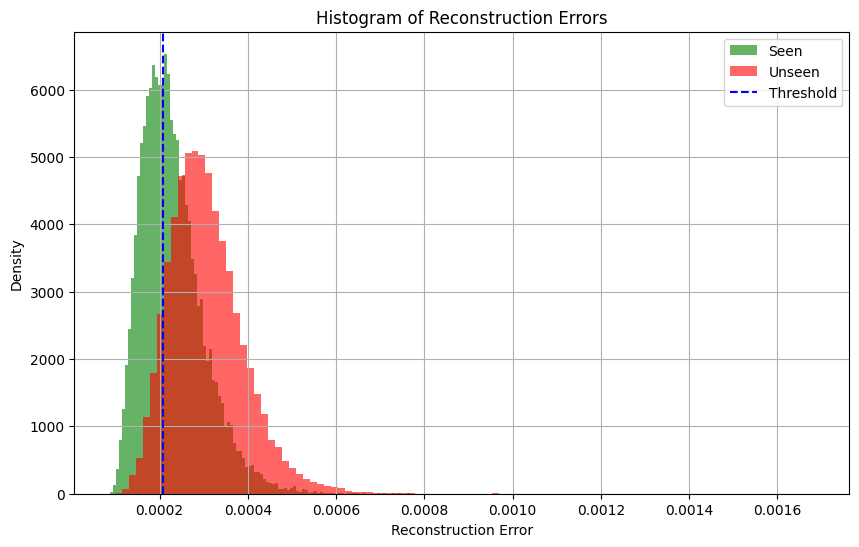

In [27]:
import torch
import matplotlib.pyplot as plt

rec_errors_seen = []
rec_errors_unseen = []

model.eval()
with torch.no_grad():
    # Seen (label 0 in your calibration set)
    for images, label in calibration_loader:
        images = images.to(device)
        label = label.to(device)
        
        logits, rec_output, cls_token = model(images)
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1).cpu().numpy()
        
        for i in range(len(label)):
            if label[i] == 0:
                rec_errors_seen.append(rec_error[i])
            else:
                rec_errors_unseen.append(rec_error[i])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(rec_errors_seen, bins=100, alpha=0.6, label='Seen', color='green', density=True)
plt.hist(rec_errors_unseen, bins=100, alpha=0.6, label='Unseen', color='red', density=True)
plt.axvline(x=anomaly_threshold, color='blue', linestyle='--', label='Threshold')
plt.title("Histogram of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.savefig("./mae_finetune_outputs/reconstruction_histogram.png", dpi=300)
plt.show()


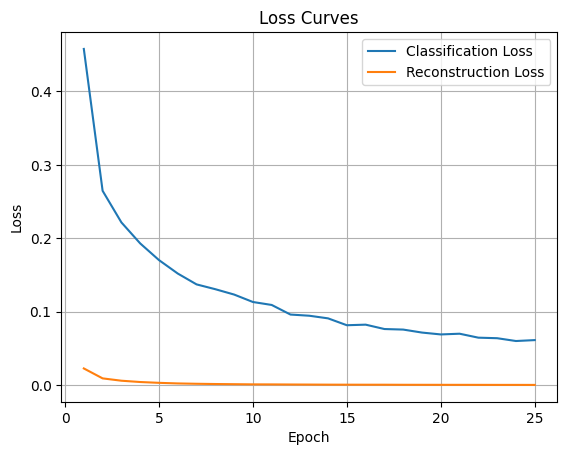

In [28]:
epochs = [e['epoch'] for e in training_log["epochs"]]
cls_losses = [e['avg_class_loss'] for e in training_log["epochs"]]
rec_losses = [e['avg_rec_loss'] for e in training_log["epochs"]]

plt.plot(epochs, cls_losses, label="Classification Loss")
plt.plot(epochs, rec_losses, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.grid(True)
plt.savefig("./mae_finetune_outputs/loss_curves.png", dpi=300)
plt.show()


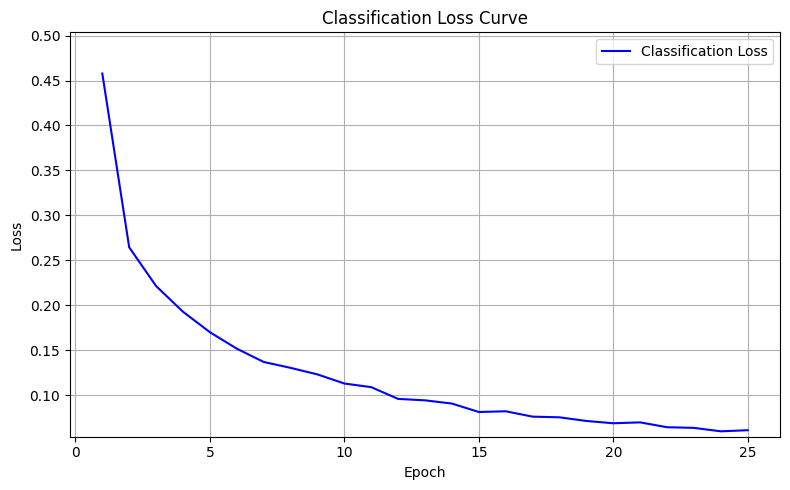

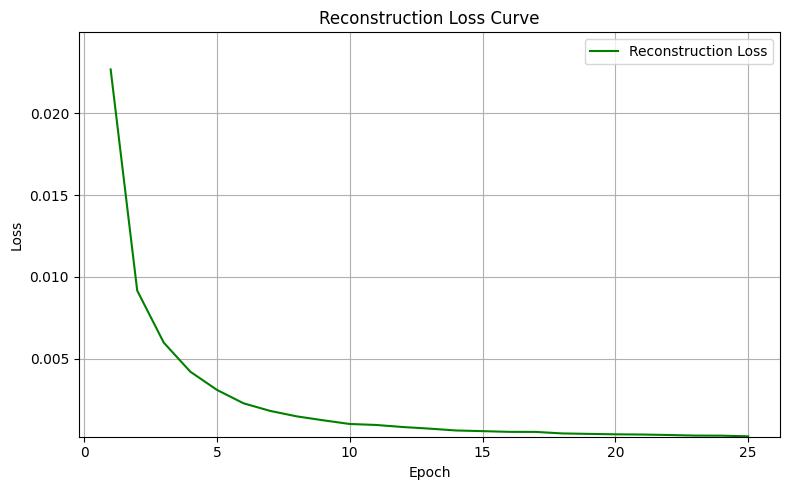

In [30]:
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
os.makedirs("./mae_finetune_outputs", exist_ok=True)

# Classification Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, cls_losses, color='blue', label="Classification Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classification Loss Curve")
plt.ylim(min(cls_losses)*0.9, max(cls_losses)*1.1)  # Zoom in
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./mae_finetune_outputs/classification_loss.png", dpi=300)
plt.show()

# Reconstruction Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, rec_losses, color='green', label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Reconstruction Loss Curve")
plt.ylim(min(rec_losses)*0.9, max(rec_losses)*1.1)  # Zoom in
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./mae_finetune_outputs/reconstruction_loss.png", dpi=300)
plt.show()


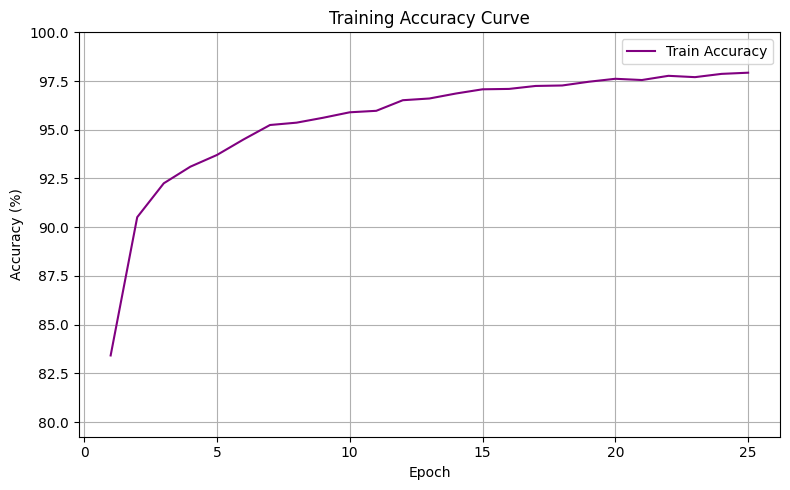

In [31]:
train_accs = [e['train_acc'] for e in training_log["epochs"]]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accs, color='purple', label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.ylim(min(train_accs)*0.95, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./mae_finetune_outputs/train_accuracy.png", dpi=300)
plt.show()